# NYC Crime Trends:
### What are the primary factors influencing crime?
**Main Dataset:** https://www.kaggle.com/datasets/mrmorj/new-york-city-police-crime-data-historic

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
pd.set_option('display.max_columns', None)

In [ ]:
crime_data = pd.read_csv('Full_crimedata_with_zip.csv', dtype={'ZIP': str})

## Location-Based Trends

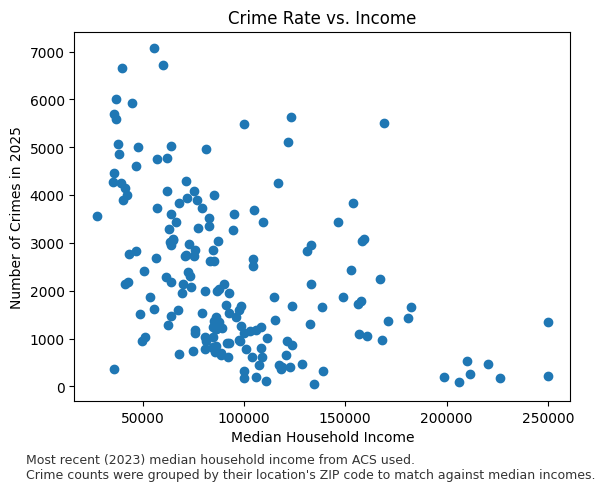

In [15]:
with open('household_income/zip_median.json', 'r') as file:
  zip_median = json.load(file)

x_vals = []
y_vals = []
for zip, income in zip_median.items():
  crime_count = len(crime_data[crime_data['ZIP'] == zip])
  x_vals.append(income)
  y_vals.append(crime_count)
plt.scatter(x_vals, y_vals)
plt.title('Crime Rate vs. Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Crimes in 2025')
plt.figtext(
  0.05, -.05,
  'Most recent (2023) median household income from ACS used.\n' +
  'Crime counts were grouped by their location\'s ZIP code to match against median incomes.',
  fontsize=9, c='#333333'
);

Crimes are more likely to happen in areas with lower household incomes.

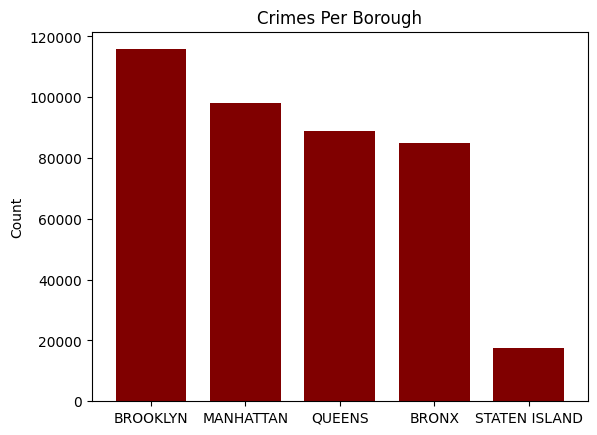

In [139]:
counts = crime_data['BORO_NM'].value_counts();
del counts['(null)']
counts.plot(kind='bar', width=.75, color='maroon')
plt.xticks(rotation=0)
plt.title('Crimes Per Borough')
plt.xlabel('')
plt.ylabel('Count');

Somewhat more crimes happen in Brooklyn compared to other boroughs, though the first four are fairly similar. Staten Island has a much lower crime rate compared to the first four.

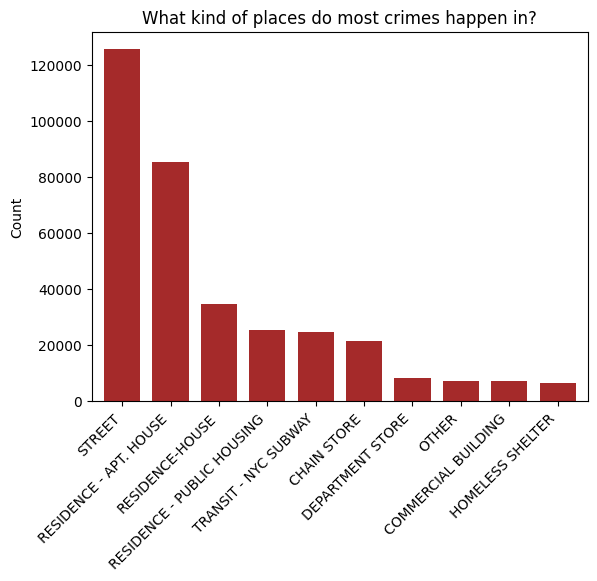

In [142]:
crime_data['PREM_TYP_DESC'].value_counts()[:10].plot(kind='bar', width=.75, color='brown')
plt.xticks(rotation=45, ha='right')
plt.title('What kind of places do most crimes happen in?')
plt.xlabel('')
plt.ylabel('Count');

## Time-Based Trends

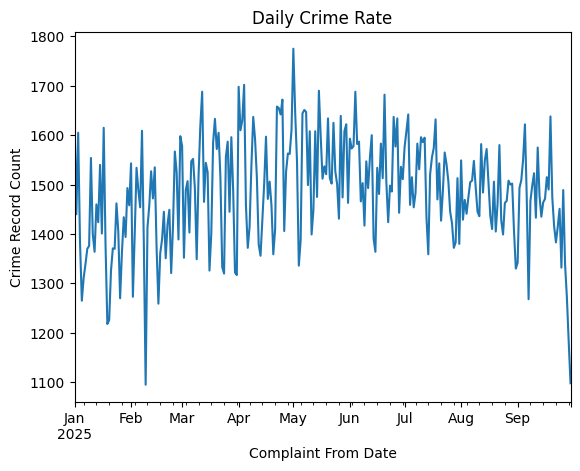

In [11]:
pd.to_datetime(crime_data['CMPLNT_FR_DT']).value_counts().sort_index().plot(kind='line')
plt.title('Daily Crime Rate')
plt.xlabel('Complaint From Date')
plt.ylabel('Crime Record Count')
plt.axvline();

More crimes happened overall around the summer compared to other seasons, spiking on May. 

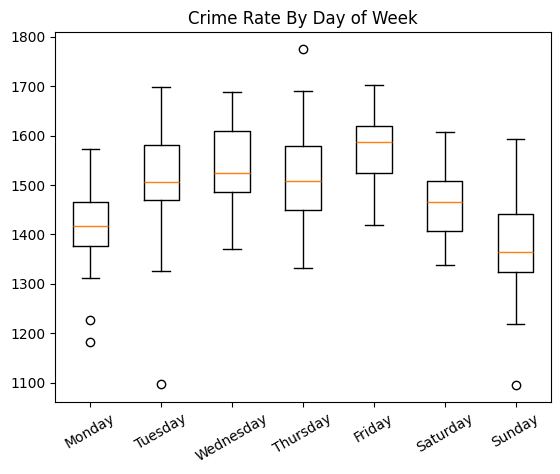

In [31]:
date_crimes = pd.to_datetime(crime_data['CMPLNT_FR_DT']).value_counts().sort_index()
dayweek_count = [(t.dayofweek, c) for t, c in date_crimes.items()]
plt.boxplot([[c for t, c in dayweek_count if t == i] for i in range(0,7)])
import calendar

day_names = [calendar.day_name[i] for i in range(7)] 
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=day_names, rotation=30)
plt.title('Crime Rate By Day of Week');

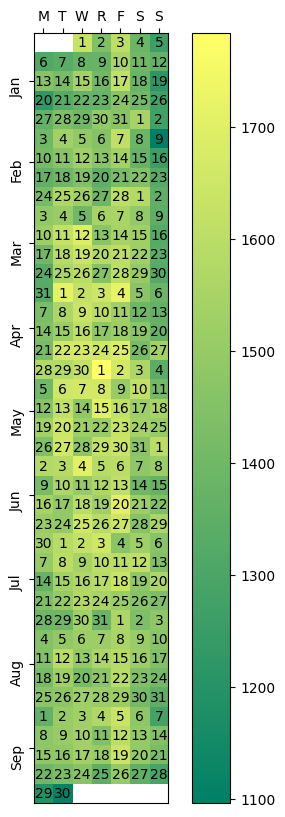

In [ ]:
# calendar heatmap (probably won't keep, the code is not mine)

# Source - https://stackoverflow.com/a
# Posted by Joe Kington
# Retrieved 2025-12-03, License - CC BY-SA 3.0

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='summer')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

fig, ax = plt.subplots(figsize=(6, 10))
calendar_heatmap(ax, date_crimes.index, date_crimes)

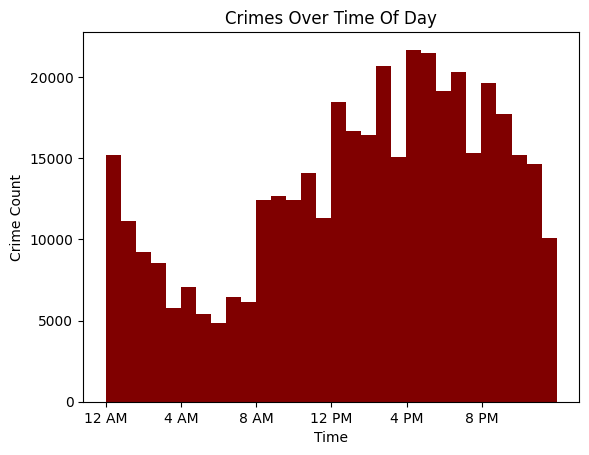

In [88]:
def time_to_seconds(time):
  return np.array(time.split(':'), dtype=int) @ [3600, 60, 1]

times = [time_to_seconds(t) for t in crime_data['CMPLNT_FR_TM']]
plt.hist(times, bins=30, color='maroon')
plt.title('Crimes Over Time Of Day')
plt.xticks(
  np.array([0, 1, 2, 3, 4, 5]) * (86400/6),
  ['12 AM', '4 AM', '8 AM', '12 PM', '4 PM', '8 PM']
);
plt.xlabel('Time')
plt.ylabel('Crime Count');

In NYC, crimes are least likely to happen at early hours in general.

## Victim/Suspect Identity

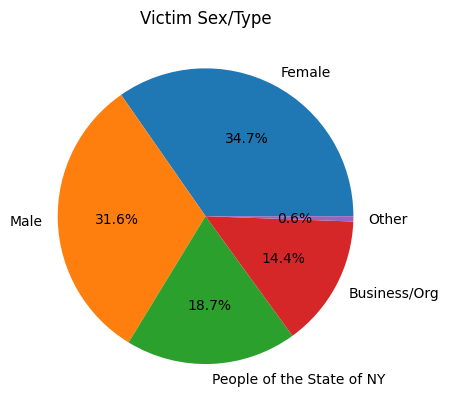

In [ ]:
counts = crime_data['VIC_SEX'].value_counts()
sex_map = {'M': 'Male', 'F': 'Female', 'E': 'People of the State of NY', 'D': 'Business/Org', 'L': 'Other'}
plt.pie(counts, labels=counts.index.map(sex_map), autopct='%1.1f%%')
plt.title('Victim Sex/Type');

There is not a strong correlation here indicating one sex is more likely to be a victim of a crime over another.

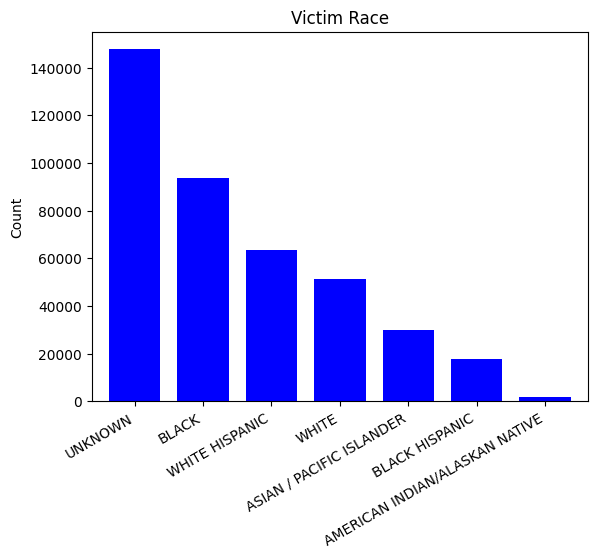

In [161]:
counts = crime_data['VIC_RACE'].value_counts()
del counts['(null)']
counts.plot(kind='bar', width=.75, color='blue')
plt.xticks(rotation=30, ha='right')
plt.title('Victim Race')
plt.xlabel('')
plt.ylabel('Count');

Blacks and white hispanics are disproportionately victims of crime in NYC.

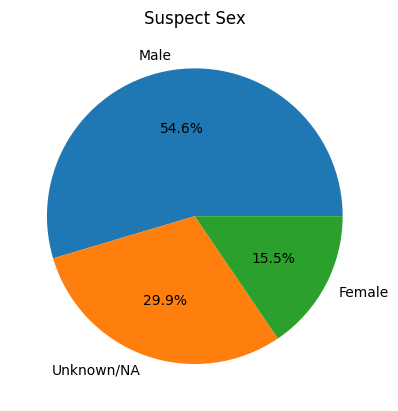

In [156]:
counts = crime_data['SUSP_SEX'].value_counts()
counts['U'] += counts['(null)']
del counts['(null)']
sex_map = {'M': 'Male', 'F': 'Female', 'U': 'Unknown/NA'}
plt.pie(counts, labels=counts.index.map(sex_map), autopct='%1.1f%%')
plt.title('Suspect Sex');

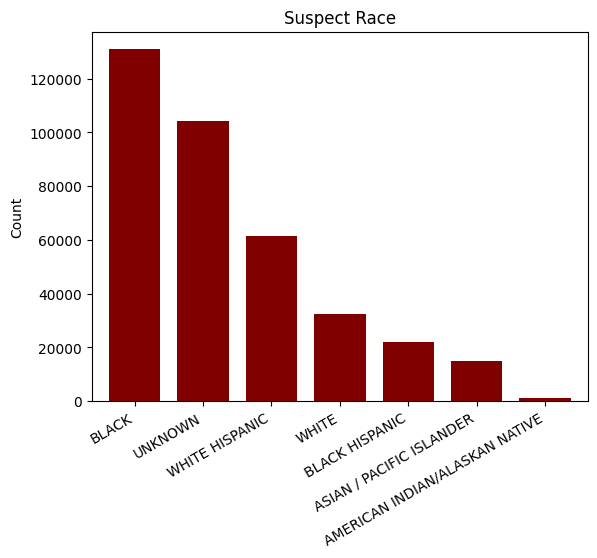

In [163]:
counts = crime_data['SUSP_RACE'].value_counts()
del counts['(null)']
counts.plot(kind='bar', width=.75, color='maroon')
plt.xticks(rotation=30, ha='right')
plt.title('Suspect Race')
plt.xlabel('')
plt.ylabel('Count');

The distribution of suspect races is actually quite similar to the distribution of victim races.

## What kinds of crime?

Text(0.5, 0, '')

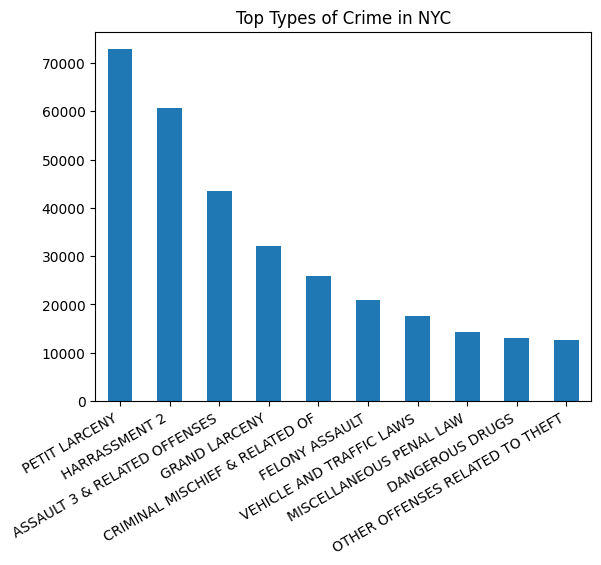

In [10]:
crime_data['OFNS_DESC'].value_counts()[:10].plot(kind='bar')
plt.xticks(rotation=30, ha='right')
plt.title('Top Types of Crime in NYC')
plt.xlabel('')